# Clusters Analysis
This notebook is used to be able to analyze the clusters obtained after clustering with KMeans.<br>
It allows to visualize imbalances between clusters and cluster's samples, and to save desired images.

## Setup
Execute this cell before the other ones.

In [1]:
import os
import json
import re
from pathlib import Path
import sys
sys.path.append('..')
from src.config import *


def load_clustering_data() -> dict:
    '''
    Load clustering data as a dictionary in the form {k, data}.
    
    Parameters:
        None
    
    Returns:
        dict: The dictionary in the form {k, data}
    '''
    # get all the clustering json files (we have to ingore other types of json files)
    clustering_filename = re.sub(r'\d+', '*', get_clustering_filename(MIN_N_CLUSTERS))
    json_files = list(Path(CLUSTERING_DIRECTORY).glob(clustering_filename))

    def get_k_from_json(json_file):
        # get k value from a json
        with open(json_file, "r") as f:
            data = json.load(f)
        return data.get("k", 0)

    # sort for k
    json_files = sorted(json_files, key=get_k_from_json)

    clustering_data = {}
    for json_file in json_files:
        with open(json_file, "r") as f:
            data = json.load(f)
        clustering_data[data['k']] = data

    return clustering_data


# load all json in a dictionary {k, data}
clustering_data = load_clustering_data()

## All Imbalances Visualization
For each row there is a K (n_clusters), and every square rapresents a cluster.<br>
The color of the cluster depends on how close or far its number of points is from the mean number of points, that all clusters should have for that specific K.<br>
For example, if we have K = 10 and 200 images, all clusters should have 20 images, in order to have balanced clusters.

Note that it might be difficult to obtain a triangle that is all around mean, since some K are more significant than others, and there might be some conflicts between those.

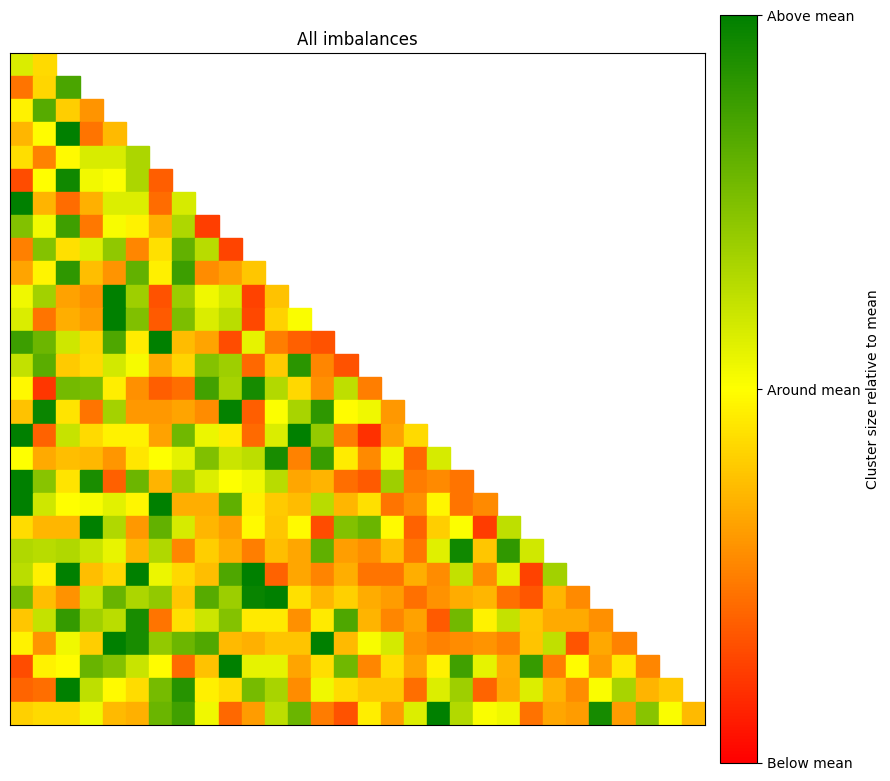

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sys
sys.path.append(str(Path("../src").resolve()))
from config import *

# build a list that will containt cluster_counts lists
cluster_lists = [clustering_data[k]["cluster_counts"] for k in range(MIN_N_CLUSTERS, MAX_N_CLUSTERS + 1)]

# determine dimensions
max_cols = max(len(row) for row in cluster_lists)
n_rows = len(cluster_lists)
figsize = (9, 9)

fig, ax = plt.subplots(figsize=figsize)

# uniform divergent colormap
cmap = mcolors.LinearSegmentedColormap.from_list("imbalance_cmap", ["red", "yellow", "green"])

for row_idx, cluster_row in enumerate(cluster_lists):
    k = len(cluster_row)
    N = sum(cluster_row)
    mean_val = N / k

    # uniform normalization: below mean (red) -> around mean (yellow) -> above mean (green)
    norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=mean_val, vmax=2*mean_val)
    
    for col_idx, value in enumerate(cluster_row):
        color = cmap(norm(value))
        rect = plt.Rectangle((col_idx, n_rows - row_idx - 1), 1, 1, color=color)
        ax.add_patch(rect)

# set axis
ax.set_xlim(0, max_cols)
ax.set_ylim(0, n_rows)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.set_title("All imbalances")

# color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.05, pad=0.02)
cbar.set_label('Cluster size relative to mean')
cbar.set_ticks([0, mean_val, 2*mean_val])
cbar.set_ticklabels(['Below mean', 'Around mean', 'Above mean'])

plt.tight_layout()
plt.show()


## Clusters Visualizations
Select a K (n_clusters) and a Cluster ID to visualize a specific cluster.<br>
You can save the image in a predefined path in the project.

In [ ]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
import sys
sys.path.append(str(Path("../src").resolve()))
from config import *



def find_image_path(image_name: str) -> str | None:
    '''
    Find the complete path given the image name.
    
    Parameters:
        image_name (str): The name of the image
    
    Returns:
        str o None: Complete path if found, None otherwise
    '''
    for ext in IMAGES_DATA_EXTENSIONS:
        for candidate_ext in [ext.lower(), ext.upper()]:
            candidate_path = os.path.join(IMAGES_DATA_DIRECTORY, image_name + candidate_ext)
            if os.path.exists(candidate_path):
                return candidate_path
    return None

# ==============================================================

def show_scores(inertia_score: float, silhouette_score: float):
    '''
    Shows the scores of KMeans for a specific k.

    Parameters:
    inertia_score (float): Inertia Score
    silhouette_score (float): Silhouette Score

    Returns:
    None
    '''
    print(f"Inertia Score: {inertia_score}")
    print(f"Silhouette Score: {silhouette_score}\n")


def show_cluster_count(cluster_counts: list, save=False):
    '''
    If save = False, shows the cluster counts's graph as an image in the notebook, otherwise save the image as a .png.

    Parameters:
    k (int): The number of cluster
    cluster_id (int): The cluster id among all the clusters
    cluster_centroid (str): The name of the image that is the centroid
    cluster_samples (list): The list of image's names that are the samples
    max_per_row (int): The amount of images to show for each row
    save (bool): If the function has to save or not the image

    Returns:
    None
    '''
    if not all(isinstance(x, int) for x in cluster_counts):
        raise ValueError("cluster_counts has to be a list of integers")
    
    k = len(cluster_counts)
    
    if k < MIN_N_CLUSTERS or k > MAX_N_CLUSTERS:
        raise ValueError(f"cluster_counts has to have a number of cluster in the interval: [{MIN_N_CLUSTERS}, {MAX_N_CLUSTERS}]")

    min_width, max_width = 6, 18
    
    n_clusters = k
    width = min_width + (max_width - min_width) * (n_clusters - MIN_N_CLUSTERS) / (MAX_N_CLUSTERS - MIN_N_CLUSTERS)
    height = 4

    plt.figure(figsize=(width, height))

    df_counts = pd.DataFrame({"count": cluster_counts})

    ax = sns.barplot(x=df_counts.index, y="count", data=df_counts)

    plt.xlabel("Cluster ID")
    plt.ylabel("Number of images")
    plt.title("Distribution of images in clusters")
    
    ax.bar_label(ax.containers[0])

    if save:
        output_image_path = os.path.join(CLUSTER_COUNTS_IMAGES_DIRECTORY, get_cluster_counts_image_filename(k))
        plt.savefig(output_image_path, bbox_inches='tight')
        print(f"Saved in {output_image_path}")
        plt.close()
    else:
        plt.show()


def show_centroid_and_samples(k: int, cluster_id: int, cluster_centroid: str, cluster_samples: list, max_per_row=5, save=False) -> None:
    '''
    If save = False, shows the centroid and the samples as an image in the notebook, otherwise save the image as a .png.

    Parameters:
    k (int): The number of cluster
    cluster_id (int): The cluster id among all the clusters
    cluster_centroid (str): The name of the image that is the centroid
    cluster_samples (list): The list of image's names that are the samples
    max_per_row (int): The amount of images to show for each row
    save (bool): If the function has to save or not the image

    Returns:
    None
    '''
    if k < MIN_N_CLUSTERS or k > MAX_N_CLUSTERS:
        raise ValueError(f"k has to be in the interval [{MIN_N_CLUSTERS}, {MAX_N_CLUSTERS}]")
    
    if cluster_id < 0 or cluster_id >= k:
        raise ValueError(f"cluster_id has to be in the interval [0, {k - 1}]")

    if not all(isinstance(x, str) for x in cluster_samples):
        raise ValueError("cluster_samples has to be a list of names")
    
    if max_per_row < 1:
        raise ValueError("max_per_row has to be greater than 0")

    n_images = len(cluster_samples)
    n_cols = min(max_per_row, n_images)
    n_rows = 1 + (n_images + n_cols - 1) // n_cols  # 1 + because there is the row for the centroid

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3 + 1))
    if n_rows == 1:
        axes = np.array([axes])

    axes = axes.reshape(n_rows, n_cols)

    # initial info to identify cluster and about the images
    message = f"K = {k}, Cluster ID = {cluster_id}\nThe first image is the centroid, the others are some samples in order from closest to centroid (first) to furthest from centroid (last)."
    fig.suptitle(message, fontsize=12, y=1.0) 

    # show centroid in the first row and column
    centroid_ax = axes[0, 0]
    centroid_path = find_image_path(cluster_centroid)
    if centroid_path:
        img = Image.open(centroid_path)
        centroid_ax.imshow(img)
    else:
        centroid_ax.text(0.5, 0.5, f"File {cluster_centroid} not found", ha='center', va='center', color='red')
    centroid_ax.set_title(f"Centroid: {cluster_centroid}", fontsize=9)
    centroid_ax.axis('off')

    for ax in axes[0, 1:]:
        ax.axis('off')

    # show samples
    flat_axes = axes[1:].flatten() if n_rows > 1 else []
    for ax, img_name in zip(flat_axes, cluster_samples):
        image_path = find_image_path(img_name)
        if image_path:
            img = Image.open(image_path)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, f"File {img_name} not found", ha='center', va='center', color='red')
        ax.set_title(img_name, fontsize=8)
        ax.axis('off')

    for ax in flat_axes[len(cluster_samples):]:
        ax.axis('off')

    plt.tight_layout()   

    if save:
        output_image_path = os.path.join(CLUSTER_IMAGES_DIRECTORY, get_cluster_image_filename(k, cluster_id))
        plt.savefig(output_image_path, bbox_inches='tight')
        clear_output()
        print(f"Saved in {output_image_path}")
        plt.close()
    else:
        plt.show()

# ==============================================================


def on_save_cluster_button_click(b):
    '''
    Function executed when the 'Save Cluster' button is clicked.
    Calls a function to save cluster image.
    '''
    cluster_id = cluster_widget.value
    with output_save_cluster_button:
        clear_output()  # clear previous messages
        if cluster_id == 'Select':
            print("Select a valid cluster")
            return

        data = clustering_data[k_widget.value]
        cluster_centroid = data["centroids"][cluster_id]
        cluster_samples = data["samples"][cluster_id]

        # save the image
        print("Saving...")
        show_centroid_and_samples(k_widget.value, cluster_id, cluster_centroid, cluster_samples, save=True)


def on_save_cluster_counts_button_click(b):
    '''
    Function executed when the 'Save Cluster Counts' button is clicked.
    Calls a function to save cluster_counts's graph image.
    '''
    with output_save_cluster_counts_button:
        clear_output()  # clear previous messages

        data = clustering_data[k_widget.value]
        cluster_counts = data["cluster_counts"]

        # save the image
        show_cluster_count(cluster_counts, save=True)


# ==============================================================


# k selection
k_widget = widgets.Dropdown(
    options=sorted(clustering_data.keys()),
    description='Select K:'
)

# cluster id selection
cluster_widget = widgets.Dropdown(
    options=['Select'],
    value='Select',
    description='Cluster ID'
)

# save cluster counts button
save_cluster_counts_button = widgets.Button(
    description="Save Cluster Counts",
    tooltip="Save cluster counts's graph as an image"
)

# save cluster button
save_cluster_button = widgets.Button(
    description="Save Cluster",
    tooltip="Save cluster as an image"
)


# output to show results
output_k = widgets.Output()
output_cluster = widgets.Output()
output_save_cluster_counts_button = widgets.Output()
output_save_cluster_button = widgets.Output()


def on_k_change(change):
    '''
    Callback function triggered when the value of the 'k' widget changes.
    Updates the displayed clustering information based on the newly selected k.
    '''
    if change['name'] == 'value':

        k = change['new']

        # update output of first widget
        with output_k:
            clear_output()
            print(f"You selected K = {k}\n")

            data = clustering_data[k]
            inertia_score = data.get("inertia_score")
            silhouette_score = data.get("silhouette_score")
            cluster_counts = data.get("cluster_counts")

            show_scores(inertia_score, silhouette_score)
            show_cluster_count(cluster_counts)
        
        # reset second widget to 'Select'
        new_options = ['Select'] + list(range(k))
        cluster_widget.options = new_options
        cluster_widget.value = 'Select'

        # reset output_save_cluster_button output
        with output_save_cluster_button:
            clear_output()
        
        # reset output_save_cluster_counts_button
        with output_save_cluster_counts_button:
            clear_output()


def on_action_change(change):
    '''
    Callback function triggered when the value of the 'cluster_id' widget changes.
    Updates the displayed cluster image based on the newly selected cluster_id.
    '''
    if change['name'] == 'value':

        cluster_id = change['new']

        with output_cluster:
            clear_output()
            if change['new'] != 'Select':
                print(f"You selected Cluster ID = {cluster_id}\n")

                data = clustering_data[k_widget.value]
                centroids = data["centroids"]
                samples = data["samples"]
                
                show_centroid_and_samples(k_widget.value, cluster_id, centroids[cluster_id], samples[cluster_id])

        # reset output_save_cluster_button
        with output_save_cluster_button:
            clear_output()


# connect functions to widgets
k_widget.observe(on_k_change)
cluster_widget.observe(on_action_change)
save_cluster_counts_button.on_click(on_save_cluster_counts_button_click)
save_cluster_button.on_click(on_save_cluster_button_click)

# visualize all
display(
    k_widget,
    output_k,
    save_cluster_counts_button,
    output_save_cluster_counts_button,
    cluster_widget,
    save_cluster_button,
    output_save_cluster_button,
    output_cluster
)

# initialize output first widget
on_k_change({'name': 'value', 'new': k_widget.value})
